In [1]:
!pip install SALib

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import numpy as np
import json
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import multiprocessing
import random
import time

from SALib.sample import saltelli
from SALib.analyze import sobol

from generators import scalefreegen as sfg

In [3]:
def WriteToJSON(in_data, in_file_path):
    json_str = json.dumps(in_data)
    json_bytes = json_str.encode('utf-8')
    with open(in_file_path, 'wb') as fout:
        fout.write(json_bytes)
        
def ReadFromJSON(in_file_path):
    with open(in_file_path, 'rb') as fin:
        json_bytes = fin.read()
    json_str = json_bytes.decode('utf-8')
    data = json.loads(json_str)
    return data

"""Use the following function to read the neighbors json file"""
def ReadNeighborsAsIntegers(in_file_path):
    # read data as string
    data = ReadFromJSON(in_file_path)
    # convert all node ids to integers
    data = {int(k):[int(e) for e in v] for k,v in data.items()}
    return data

## Generalized Model Definition

In [4]:
""" Named Constants used for addressing the indexes of model Node States """
NS_STATE = 0
NS_NEXT_STATE = 1
NS_WAS_ACTIVATED_PREV_STEP = 2
NS_INIT_STATE = 3
NS_INIT_WAS_ACTIVATED_PREV_STEP = 4

""" Reads the network from the given inNeighbors.json file """
def read_network(in_network_file):
    node_in_neighbors = ReadNeighborsAsIntegers(in_network_file)
    name_parts = os.path.basename(in_network_file).split('_')
    #print(name_parts)
    network_index = int(name_parts[1])
    network_size = int(name_parts[2][1:])
    beta = float((name_parts[3][1:]).replace('o','.'))
    din = float((name_parts[4][3:]).replace('o','.'))
    dout = float((name_parts[5][4:]).replace('o','.'))
    net = {"id" : network_index,
           "size": network_size,
           "beta": beta,
           "delta_in": din,
           "delta_out": dout,
           "in_neighbors": node_in_neighbors,
           }
    return net

""" Given a network data read from a file, creates and initializes a usable simulation instance for DOI experiments
    Susceptible == False
    Infected == True
    Returns created simulation dictionary object
"""
def setup_simulation_instance(in_network, in_init_fract_infection):
    network_size = in_network["size"]
    NodeState = np.zeros((5, network_size), dtype=bool)
    init_infected_nodeidx_list = np.random.choice(network_size, round(in_init_fract_infection * network_size), replace=False)
    NodeState[NS_INIT_STATE, init_infected_nodeidx_list] = True
    NodeState[NS_INIT_WAS_ACTIVATED_PREV_STEP, init_infected_nodeidx_list] = True
    #print(f"Initial infected nodes: {len(init_infected_nodeidx_list)}")
    sim = {"NodeState": NodeState, "InitInfects":init_infected_nodeidx_list}
    return sim
    
""" Copies initial states to the current states of nodes """
def initialize(in_network, inout_simulation):
    NodeState = inout_simulation["NodeState"]
    NodeState[NS_STATE] = NodeState[NS_INIT_STATE]
    NodeState[NS_NEXT_STATE] = NodeState[NS_INIT_STATE]
    NodeState[NS_WAS_ACTIVATED_PREV_STEP] = NodeState[NS_INIT_WAS_ACTIVATED_PREV_STEP]
    
   
""" Runs the simulation """
def run(inout_simulation, in_network, in_model, in_max_steps=10000):
    
    infection_at_step = []
    
    network_size = in_network["size"]
    NodeState = inout_simulation["NodeState"]
    
    in_model.setup(in_network, inout_simulation)
    
    for step in (range(in_max_steps)):
        
        infection_at_this_step = 0

        # Process F > G for all Susceptible nodes and mark for state change
        for node_idx in range(network_size):
            if not NodeState[NS_STATE, node_idx]:
                # execute following for all Susceptible
                F = in_model.F(node_idx, NodeState, in_network["in_neighbors"], inout_simulation)
                G = in_model.G()
                if G <= F:
                    NodeState[NS_NEXT_STATE, node_idx] = True
        
        # Reset excitement of all nodes back
        NodeState[NS_WAS_ACTIVATED_PREV_STEP] = False
        
        for node_idx in range(network_size):
            if not NodeState[NS_STATE, node_idx] and NodeState[NS_NEXT_STATE, node_idx]:
                NodeState[NS_WAS_ACTIVATED_PREV_STEP, node_idx] = True
                infection_at_this_step += 1
        
        # Copy the next state onto state
        NodeState[NS_STATE] = NodeState[NS_NEXT_STATE]

        infection_at_step.append( infection_at_this_step )
        
        # stop if no change for 1000 steps
        if step > 1000 and step % 1000 == 1 and np.sum(infection_at_step[-1000:]) == 0:
            #print("No change for 1000 steps")
            break

    inout_simulation["InfectionAtStep"] = infection_at_step
    inout_simulation["StopAt"] = step
    return

### Instances of the generalized Model

In [5]:
class LATM:
    def __init__(self, in_threshold):
        self.threshold = in_threshold
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        return len(infected_neighborhood)

    def G(self):
        return self.threshold


In [6]:
class LFTM:
    def __init__(self, in_threshold):
        self.threshold = in_threshold
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        return len(infected_neighborhood) / len(neighborhood) if len(neighborhood) > 0 else 0

    def G(self):
        return self.threshold


In [7]:
class ICM:
    def __init__(self, in_imitation):
        self.imitation = in_imitation
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        active_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_WAS_ACTIVATED_PREV_STEP, neighbor_idx]]
        return 1.0 - ((1.0 - self.imitation) ** len(active_neighborhood))

    def G(self):
        return random.random()


In [8]:
class BRRM:
    def __init__(self, in_imitation):
        self.imitation = in_imitation
    
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        I_to_N = (len(infected_neighborhood) / len(neighborhood)) if len(neighborhood) > 0 else 0
        return 1.0 - ((1.0 - self.imitation * I_to_N) ** len(infected_neighborhood))

    def G(self):
        return random.random()


In [9]:
class sBRRM:
    def __init__(self, in_imitation):
        self.imitation = in_imitation
    
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        I_to_N = (len(infected_neighborhood) / len(neighborhood)) if len(neighborhood) > 0 else 0
        return self.imitation * I_to_N

    def G(self):
        return random.random()


In [10]:
class SLFTM:
    def __init__(self, in_threshold, in_probability=0.5):
        self.threshold = in_threshold
        self.probability = in_probability
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        f = len(infected_neighborhood) / len(neighborhood) if len(neighborhood) > 0 else 0
        if self.threshold <= f:
            return self.probability
        else:
            return -1

    def G(self):
        return random.random()


In [11]:
class SLATM:
    def __init__(self, in_threshold, in_probability=0.5):
        self.threshold = in_threshold
        self.probability = in_probability
        
    def setup(self, in_network, inout_simulation):
        pass
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        f = len(infected_neighborhood)
        if self.threshold <= f:
            return self.probability
        else:
            return -1

    def G(self):
        return random.random()


In [12]:
class DWM:
    def __init__(self, in_probability, in_dose_threshold, in_dose=1.0):
        self.dose = in_dose
        self.dose_threshold = in_dose_threshold
        self.probability = in_probability
        
    def setup(self, in_network, inout_simulation):
        inout_simulation["Doses"] = [0.0 for i in range(in_network["size"])]
        
    def F(self, in_node_idx, in_NodeState, in_inNeighbors, inout_simulation):
        neighborhood = in_inNeighbors[in_node_idx] if in_node_idx in in_inNeighbors else []
        infected_neighborhood = [neighbor_idx for neighbor_idx in neighborhood if in_NodeState[NS_STATE, neighbor_idx]]
        if len(infected_neighborhood) > 0 and random.random() <= self.probability:
            inout_simulation["Doses"][in_node_idx] = self.dose + inout_simulation["Doses"][in_node_idx]
        return inout_simulation["Doses"][in_node_idx]

    def G(self):
        return self.dose_threshold
        

## EXP1 : Running Factorial Experiments

In [13]:
def run_trial(in_initial_frac_infection, in_network, in_model, in_model_param_1_name, in_model_param_1_value, in_model_param_2_name, in_model_param_2_value):
    # setup 
    sim = setup_simulation_instance(in_network, in_initial_frac_infection)

    initialize(in_network, sim)
    #print(sim['NodeState'])

    run(sim, in_network, in_model)

    #print("Stopped at : " + str(sim["StopAt"]))
    #print(sim['NodeState'])
    sim.keys()
    results = sim["InfectionAtStep"]

    #print(f"Infected by diffusion : {np.sum(results)} + Initial Infects : "+ str(len(sim["InitInfects"])) + " ==> " + str(np.sum(results) + len(sim["InitInfects"])) )
    #print(f"Final number of infected : {sim['NodeState'][NS_STATE].sum()}")

    while len(results) > 0 and results[-1] == 0:
        results.pop(-1)
    results.append(0)

    #print(f"Constant state reached at : {len(results)} steps")


    count_edges_II = 0
    count_edges_IS = 0
    count_edges_SS = 0
    count_edges_SI = 0
    count_S_nodes_with_I_neighbors = set()
    count_edges_II_prev_IS = 0
    count_edges_II_prev_SS = 0
    count_edges_IS_prev_SS = 0

    def count_edge_stats(src, dst):
        nonlocal count_edges_II
        nonlocal count_edges_IS
        nonlocal count_edges_SS
        nonlocal count_edges_SI
        nonlocal count_edges_II_prev_IS
        nonlocal count_edges_II_prev_SS
        nonlocal count_edges_IS_prev_SS
        if sim['NodeState'][NS_STATE, src]:
            if sim['NodeState'][NS_STATE, dst]:
                count_edges_II += 1
                if sim['NodeState'][NS_INIT_STATE, src]:
                    if not sim['NodeState'][NS_INIT_STATE, dst]:
                        count_edges_II_prev_IS += 1
                else:
                    if not sim['NodeState'][NS_INIT_STATE, dst]:
                        count_edges_II_prev_SS += 1
            else:
                count_edges_IS += 1
                count_S_nodes_with_I_neighbors.add(dst)
                if not sim['NodeState'][NS_INIT_STATE, src] and not sim['NodeState'][NS_INIT_STATE, dst]:
                    count_edges_IS_prev_SS += 1
        else:
            if sim['NodeState'][NS_STATE, dst]:
                count_edges_SI += 1
            else:
                count_edges_SS += 1
    
    total_edges = 0
    for dst in in_network['in_neighbors']:
        for src in in_network['in_neighbors'][dst]:
            count_edge_stats(src, dst)
            total_edges += 1

    count_edges_II /= total_edges
    count_edges_IS /= total_edges
    count_edges_SS /= total_edges
    count_edges_SI /= total_edges
    count_S_nodes_with_I_neighbors = len(count_S_nodes_with_I_neighbors)
    count_edges_II_prev_IS /= total_edges
    count_edges_II_prev_SS /= total_edges
    count_edges_IS_prev_SS /= total_edges

    final_infected_fraction = sim['NodeState'][NS_STATE].sum() / in_network['size']
    
    net_percent_value = np.sum([v * (0.9 ** t) for t,v in enumerate(sim["InfectionAtStep"])])
    #print(f"NPV={net_percent_value}")
    tot = np.sum(sim["InfectionAtStep"])
    cumsum = [v for v in sim["InfectionAtStep"]]
    for i in range(1, len(cumsum)):
        cumsum[i] += cumsum[i-1]
    cumfrac = np.array(cumsum)/tot if tot != 0 else np.array(cumsum)
    infstate = "init"
    early = 0
    mid = 0
    late = 0
    for i in range(len(cumfrac)):
        if infstate == "init" and cumfrac[i] > 0.50:
            infstate = "early"
            early = i
            #print(i, infstate)
        elif infstate == "early" and cumfrac[i] > 0.75:
            infstate = "mid"
            mid = i
            #print(i, infstate)
        elif infstate == "mid" and cumfrac[i] > 0.95:
            infstate = "late"
            late = i
            #print(i, infstate)
            
    all_stats = {
        "total_nodes": in_network['size'],
        "init_infection": in_initial_frac_infection,
        "beta": in_network['beta'], 
        in_model_param_1_name: in_model_param_1_value,
        in_model_param_2_name: in_model_param_2_value,
        "final_infection": final_infected_fraction, 
        "total_edges": total_edges, 
        "count_edges_II": count_edges_II, 
        "count_edges_IS": count_edges_IS,
        "count_edges_SS": count_edges_SS,
        "count_edges_SI": count_edges_SI, 
        "count_S_nodes_with_I_neighbors": count_S_nodes_with_I_neighbors, 
        "count_edges_II_prev_IS": count_edges_II_prev_IS,
        "count_edges_II_prev_SS": count_edges_II_prev_SS,
        "count_edges_IS_prev_SS": count_edges_IS_prev_SS,
        "net_percent_value": net_percent_value,
        "early": early,
        "mid": mid,
        "late": late,
        "final_const_state_at": len(sim["InfectionAtStep"]),
        "sim_stopped_at": sim['StopAt'],
        "InfectionAtStep": sim["InfectionAtStep"]
    }
    
    return {"Stats" : all_stats, "Simulation": sim}



In [14]:
def run_trial_set(in_network_file, in_model_name):
    np.random.seed() # <-- multiprocessing with different seeds
    print(f"Starting : {in_network_file},")
    results_set = []
    # read network file
    network = read_network(in_network_file)
    for ini_inf in np.arange(0.05,0.4,0.05):
        print(f"ii:{ini_inf},")
        if "SLATM" == in_model_name:
            for SLATMt in np.arange(1,20):
                for SLATMp in [0.05, 0.50, 0.95]:
                    results = run_trial(ini_inf, network, SLATM(SLATMt,SLATMp), "SLATM_t", SLATMt, "SLATM_p", SLATMp)
                    results_set.append(results['Stats'])
        if "LATM" == in_model_name:
            for LATMt in np.arange(1,20):
                results = run_trial(ini_inf, network, LATM(LATMt), "LATM_t", LATMt, "x", 0)
                results_set.append(results['Stats'])
        if "LFTM" == in_model_name:
            for LFTMt in np.arange(0.05,1,0.05):
                results = run_trial(ini_inf, network, LFTM(LFTMt), "LFTM_t", LFTMt, "x", 0)
                results_set.append(results['Stats'])
        if "ICM" == in_model_name:
            for ICMq in np.arange(0.05,1,0.05):
                results = run_trial(ini_inf, network, ICM(ICMq), "ICM_q", ICMq, "x", 0)
                results_set.append(results['Stats'])
        if "BRRM" == in_model_name:
            for BRRMq in np.arange(0.05,1,0.05):
                results = run_trial(ini_inf, network, BRRM(BRRMq), "BRRM_q", BRRMq, "x", 0)
                results_set.append(results['Stats'])
        if "sBRRM" == in_model_name:
            for sBRRMq in np.arange(0.05,1,0.05):
                results = run_trial(ini_inf, network, sBRRM(sBRRMq), "sBRRM_q", sBRRMq, "x", 0)
                results_set.append(results['Stats'])
        if "SLFTM" == in_model_name:
            for SLFTMt in np.arange(0.05,1,0.05):
                for SLFTMp in [0.05, 0.95]:
                    results = run_trial(ini_inf, network, SLFTM(SLFTMt,SLFTMp), "SLFTM_t", SLFTMt, "SLFTM_p", SLFTMp)
                    results_set.append(results['Stats'])
        if "DWM" == in_model_name:
            for DWMdt in range(2,10):
                for DWMq in np.arange(0.05,1,0.05):
                    results = run_trial(ini_inf, network, DWM(DWMq,DWMdt), "DWM_q", DWMq, "DWM_dt", DWMdt)
                    results_set.append(results['Stats'])
    print(f"Done,")
    df = pd.DataFrame(results_set)
    temp_folder_path = f'./doi_outputs/partial/{in_model_name}'
    if not os.path.exists(temp_folder_path):
        # need to test this......
        os.makedirs(temp_folder_path)
    df.to_csv(f'{temp_folder_path}/{in_model_name}_runs_' + str(os.path.basename(in_network_file)[:-5]) + '.csv')
    return results_set

In [15]:
def multiproc_run_trials():
    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
        mult_results = pool.starmap(run_trial_set, param_list)
        return mult_results

## Run EXP1

In [16]:
network_files = glob.glob('./outputs/v2/*.json')
network_files.sort()
network_files

['./outputs/v2/DSFN_000_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_001_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_002_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_003_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_004_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_005_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_006_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_007_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_008_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_009_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_010_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_011_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_012_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './outputs/v2/DSFN_013_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json',
 './ou

In [ ]:
start_time = time.time()

for MODEL_TO_RUN in ["sBRRM"]:
    param_list = [(fle, MODEL_TO_RUN) for fle in network_files]
    mult_results = multiproc_run_trials()
    all_results = [element for nestedlist in mult_results for element in nestedlist]
    df = pd.DataFrame(all_results)
    df.to_csv(f'./doi_outputs/{MODEL_TO_RUN}.csv')
    
end_time = time.time()

Starting : ./outputs/v2/DSFN_012_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_006_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_009_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_000_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_015_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_003_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_018_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_024_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_021_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_027_N5000_B0o050_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_033_N5000_B0o100_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_030_N5000_B0o100_dIn0o1_dOut0o1_inNeighbors.json,Starting : ./outputs/v2/DSFN_036_N5000_B0o100_dIn0o1_dOut0o1_inN

In [19]:
print((end_time - start_time)/3600)

7.7268995558553275


## Definitions for Sobol Sensitivity Analysis

In [20]:
def generateNetwork(id, beta):
    netSize = 5000
    deltaIn = 0.1
    deltaOut = 0.1
    #
    #print(f"s:{np.random.get_state()[1][0]} r:{np.random.random()}")
    net = sfg.GenerateScaleFreeNetworkByBeta(netSize, beta, deltaIn, deltaOut)
    #print(f"Generated {id}: N:{netSize} B:{beta} dIn:{deltaIn} dOut:{deltaOut}")
    #file_name = "./outputs/v2/" + f"DSFN_{id:03d}_N{netSize}_B{beta:.3f}_dIn{deltaIn}_dOut{deltaOut}".replace('.','o') + ".csv"
    dir_name = "./outputs/v2dynamic/"
    network_name = f"DSFN_{id:08d}_N{netSize}_B{beta}_dIn{deltaIn}_dOut{deltaOut}".replace('.','o')
    file_name_edgelist = dir_name + network_name + "_edgelist.csv"
    file_name_neighbors = dir_name + network_name + "_inNeighbors.json"
    #
    node_to_in_link_neighbors = {}
    def addAdjList(src, dst):
        if dst in node_to_in_link_neighbors:
            node_to_in_link_neighbors[dst].append(src)
        else:
            node_to_in_link_neighbors[dst] = [src]
    #
    for src in range(net['size']):
        for dst in range(net['size']):
            if net['edges'][src,dst] != 0:
                addAdjList(str(src), str(dst))
    #
    return node_to_in_link_neighbors, file_name_neighbors

In [21]:
manager = multiprocessing.Manager()
# dict file -> beta
# files that are already used by the algorithm
shared_filename_list = manager.list()

def getNetwork(in_beta):
    looking_for = "./outputs/v2dynamic/" + f"DSFN_*_B{in_beta}_*".replace('.','o') + ".json"
    files_list_all = glob.glob(looking_for)
    files_list = set(files_list_all).difference(shared_filename_list)
    #print(f"{in_beta} -> {len(files_list_all)} -> {len(files_list)}")
    if len(files_list) > 0:
        filename = list(files_list)[0]
        shared_filename_list.append(filename)
        #print(f"{in_beta} -> {len(files_list_all)} -> {len(files_list)}")
    else:
        netdata, filename = generateNetwork(random.randint(0, 10000000), in_beta)
        shared_filename_list.append(filename)
        WriteToJSON(netdata, filename)
    return read_network(filename)

In [31]:
def run_dynamic_trial(in_initial_frac_infection, in_network_beta, in_model, in_result_type='npv'):
    # get network dynamically
    network = getNetwork(in_network_beta)
    
    # setup 
    sim = setup_simulation_instance(network, in_initial_frac_infection)

    initialize(network, sim)
    #print(sim['NodeState'])

    run(sim, network, in_model)

    #print("Stopped at : " + str(sim["StopAt"]))
    #print(sim['NodeState'])
    
    if 'final_infection' == in_result_type:
        final_infected_fraction = (sim['NodeState'][NS_STATE].sum() - len(sim["InitInfects"])) / network['size']
        return final_infected_fraction
    else:
        net_percent_value = np.sum([v * (0.9 ** t) for t,v in enumerate(sim["InfectionAtStep"])])
        return net_percent_value

In [32]:
problem_LATM = {
    'num_vars':3,
    'names':['init_infection','beta','LATM_t'],
    'bounds':[[0.05,0.35],[0.05,0.95],[1,20]]
}

problem_SLATM = {
    'num_vars':4,
    'names':['init_infection','beta','SLATM_t','SLATM_p'],
    'bounds':[[0.05,0.35],[0.05,0.95],[0,20],[0.05,0.95]]
}

problem_LFTM = {
    'num_vars':3,
    'names':['init_infection','beta','LFTM_t'],
    'bounds':[[0.05,0.35],[0.05,0.95],[0.05,0.95]]
}

problem_SLFTM = {
    'num_vars':4,
    'names':['init_infection','beta','SLFTM_t','SLFTM_p'],
    'bounds':[[0.05,0.35],[0.05,0.95],[0.05,0.95],[0.05,0.95]]
}

problem_ICM = {
    'num_vars':3,
    'names':['init_infection','beta','ICM_q'],
    'bounds':[[0.05,0.35],[0.05,0.95],[0.05,0.95]]
}

problem_BRRM = {
    'num_vars':3,
    'names':['init_infection','beta','BRRM_q'],
    'bounds':[[0.05,0.35],[0.05,0.95],[0.05,0.95]]
}

problem_sBRRM = {
    'num_vars':3,
    'names':['init_infection','beta','sBRRM_q'],
    'bounds':[[0.05,0.35],[0.05,0.95],[0.05,0.95]]
}

problem_DWM = {
    'num_vars':4,
    'names':['init_infection','beta','DWM_q','DWM_dt'],
    'bounds':[[0.05,0.35],[0.05,0.95],[0.05,0.95],[2,10]]
}

model_problem = {"LATM": problem_LATM, "SLATM": problem_SLATM, "LFTM": problem_LFTM, "SLFTM": problem_SLFTM, "ICM": problem_ICM, "BRRM": problem_BRRM, "sBRRM": problem_sBRRM, "DWM": problem_DWM}
model_problem

{'LATM': {'num_vars': 3,
  'names': ['init_infection', 'beta', 'LATM_t'],
  'bounds': [[0.05, 0.35], [0.05, 0.95], [1, 20]]},
 'SLATM': {'num_vars': 4,
  'names': ['init_infection', 'beta', 'SLATM_t', 'SLATM_p'],
  'bounds': [[0.05, 0.35], [0.05, 0.95], [0, 20], [0.05, 0.95]]},
 'LFTM': {'num_vars': 3,
  'names': ['init_infection', 'beta', 'LFTM_t'],
  'bounds': [[0.05, 0.35], [0.05, 0.95], [0.05, 0.95]]},
 'SLFTM': {'num_vars': 4,
  'names': ['init_infection', 'beta', 'SLFTM_t', 'SLFTM_p'],
  'bounds': [[0.05, 0.35], [0.05, 0.95], [0.05, 0.95], [0.05, 0.95]]},
 'ICM': {'num_vars': 3,
  'names': ['init_infection', 'beta', 'ICM_q'],
  'bounds': [[0.05, 0.35], [0.05, 0.95], [0.05, 0.95]]},
 'BRRM': {'num_vars': 3,
  'names': ['init_infection', 'beta', 'BRRM_q'],
  'bounds': [[0.05, 0.35], [0.05, 0.95], [0.05, 0.95]]},
 'sBRRM': {'num_vars': 3,
  'names': ['init_infection', 'beta', 'sBRRM_q'],
  'bounds': [[0.05, 0.35], [0.05, 0.95], [0.05, 0.95]]},
 'DWM': {'num_vars': 4,
  'names': ['in

In [36]:
def run_model(in_model_name, in_params_list, in_result_type):
    np.random.seed() # <-- multiprocessing with different seeds
    if "LATM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], LATM(in_params_list[2]), in_result_type)
    if "SLATM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], SLATM(in_params_list[2],in_params_list[3]), in_result_type)
    if "LFTM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], LFTM(in_params_list[2]), in_result_type)
    if "SLFTM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], SLFTM(in_params_list[2],in_params_list[3]), in_result_type)
    if "ICM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], ICM(in_params_list[2]), in_result_type)
    if "BRRM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], BRRM(in_params_list[2]), in_result_type)
    if "sBRRM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], sBRRM(in_params_list[2]), in_result_type)
    if "DWM" == in_model_name:
        return run_dynamic_trial(in_params_list[0], in_params_list[1], DWM(in_params_list[2],in_params_list[3]), in_result_type)

In [37]:
def run_model_for_params_list(in_model_name, in_x_values, in_result_type):
    with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
        mult_results = pool.starmap(run_model, [(in_model_name, xval, in_result_type) for xval in in_x_values])
        return mult_results

def analyze_model(in_model_name, in_N, in_result_type):
    print(f"-----------{in_model_name} : {in_N}----------")
    print(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()))
    
    # create stratified sampling wiht saltelli method
    X_values = saltelli.sample(model_problem[in_model_name], in_N)
    print("X :", X_values.shape)
    
    # run models and get corresponding Y values 
    Y_values = np.array(run_model_for_params_list(in_model_name, X_values, in_result_type) )
    print("Y :", Y_values.shape)
    
    # run sentiment analysis
    sobol_analysis = sobol.analyze(model_problem[in_model_name], Y_values, print_to_console=True, parallel=True, n_processors=multiprocessing.cpu_count())
    
    return sobol_analysis

In [38]:
model_si = {}

In [ ]:
#for MODEL_TO_ANALYZE in ["LATM", "SLATM", "LFTM", "SLFTM", "BRRM", "sBRRM", "DWM", "ICM"]:
for MODEL_TO_ANALYZE in ["sBRRM"]:
    shared_filename_list = manager.list()
    a1 = analyze_model(MODEL_TO_ANALYZE, 2048, "final_infection")
    model_si[MODEL_TO_ANALYZE] = a1
    dfs = a1.to_df()
    dfs[0].to_csv(f"./outputs/temp/{MODEL_TO_ANALYZE}_ST.csv")
    dfs[1].to_csv(f"./outputs/temp/{MODEL_TO_ANALYZE}_S1.csv")
    dfs[2].to_csv(f"./outputs/temp/{MODEL_TO_ANALYZE}_S2.csv")

-----------sBRRM : 2048----------
2023-06-11 11:15:39
X : (16384, 3)


/tmp/ipykernel_16031/323441497.py:11: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  X_values = saltelli.sample(model_problem[in_model_name], in_N)


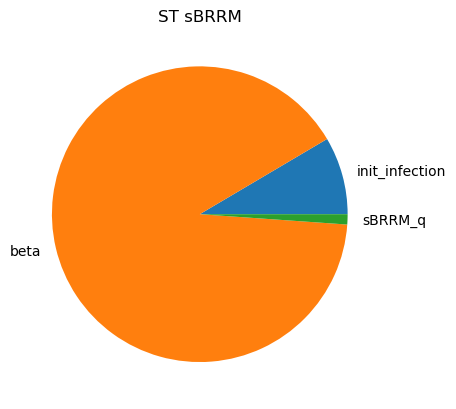

In [46]:
for modelkey in model_si:
    fig, ax = plt.subplots()
    ax.pie(model_si[modelkey]['ST'], labels=model_problem[modelkey]['names'])
    plt.title(f"ST {modelkey}")
    plt.show()

In [ ]:
for model in model_si:
    dfs = model_si[model].to_df()
    dfs[0].to_csv(f"./outputs/{model}_ST.csv")
    dfs[1].to_csv(f"./outputs/{model}_S1.csv")
    dfs[2].to_csv(f"./outputs/{model}_S2.csv")

In [45]:
model_si

{'sBRRM': {'S1': array([ 0.0102524 ,  0.90033361, -0.00109721]),
  'S1_conf': array([0.01923467, 0.05143637, 0.00710152]),
  'ST': array([0.09350603, 0.99512472, 0.01227467]),
  'ST_conf': array([0.00589679, 0.05670312, 0.00104851]),
  'S2': array([[       nan, 0.07697895, 0.00394927],
         [       nan,        nan, 0.0014655 ],
         [       nan,        nan,        nan]]),
  'S2_conf': array([[       nan, 0.03036504, 0.03207829],
         [       nan,        nan, 0.05792878],
         [       nan,        nan,        nan]])}}

In [44]:
2 ** 11

2048

In [ ]:
saltelli.sample(model_problem["ICM"], 1024).shape

In [ ]:
def npv(in_list):
    return np.sum([v * (0.9 ** t) for t,v in enumerate(in_list)])

def nnpv(in_list):
    n = len(in_list)
    return [0.9 ** (100 * i / n) for i in range(n)]

l = [ 10 - i for i in range(10)]
print(l)

In [ ]:
v1 = npv(l)
v2 = np.sum(l)
v1, v2, v1/v2

In [ ]:
n = 10
l = [ n - i for i in range(n)]
print(l)

In [ ]:
m = [i/n for i in range(n)]
print(m)

In [ ]:
o = [0.9 ** (100 * i / n) for i in range(n)]
print(o)

In [ ]:
p = [l[i] * (0.9 ** (100 * i / n)) for i in range(n)]
print(p)
print(np.sum(p))

In [ ]:
print([ 0.9 ** i for i in range(100)])